In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import FastText
from nltk.tokenize import word_tokenize

In [2]:
train_df = pd.read_csv("train_df2.csv")
train_df

,Unnamed: 0,prompt_id,text,generated
0,0,0,Cars. Cars have been around since they became ...,0
1,1,0,Transportation is a large necessity in most co...,0
2,2,0,Americas love affair with its vehicles seems t...,0
3,3,0,How often do you ride in a car Do you drive a ...,0
4,4,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
2629,2773,1,letter_to_state_senator \n recipient Senator L...,1
2630,2774,0,Limiting car usage offers numerous advantages ...,1
2631,2775,1,letter \n recipient State Senator\n address St...,1
2632,2776,0,Due to the character limit I cannot provide a ...,1


## Build text classifiers on the augmented data, using cross validation with appropriate classification evaluation metrics to assess them, and suggest the best performing one.

In [3]:
def k_fold_cross_validation(model, X, y, k=10):
   
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = []
    f1_scores = []
    
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        vectorizer = TfidfVectorizer()
        X_train, y_train = vectorizer.fit_transform(X_train), y_train
        X_test, y_test = vectorizer.transform(X_test), y_test
        X_train_dense = X_train.toarray()
        X_test_dense = X_test.toarray()
        
        model.fit(X_train_dense, y_train)

        y_pred = model.predict(X_test_dense)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
    mean_accuracy = np.mean(accuracy_scores)
    mean_f1_score = np.mean(f1_scores)
    mean_accuracy_std = np.std(accuracy_scores)

    return mean_accuracy, mean_f1_score, mean_accuracy_std

In [4]:
X_train, X_test, y_train, y_test = train_test_split(train_df.text, train_df.generated,test_size=0.25, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
naive_bayes_classifier = GaussianNB()
logistic_regression_classifier = LogisticRegression()
linear_svm_classifier = SVC(kernel='linear')
nonlinear_svm_classifier = SVC(kernel='rbf')
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Run k-fold cross-validation for each classifier
nb_accuracy, nb_f1, nb_std = k_fold_cross_validation(naive_bayes_classifier, X_train, y_train)
lr_accuracy, lr_f1, lr_std = k_fold_cross_validation(logistic_regression_classifier, X_train, y_train)
linear_svm_accuracy, linear_svm_f1, linear_svm_std = k_fold_cross_validation(linear_svm_classifier, X_train, y_train)
nonlinear_svm_accuracy, nonlinear_svm_f1, nonlinear_svm_std = k_fold_cross_validation(nonlinear_svm_classifier, X_train, y_train)
knn_accuracy, knn_f1, knn_std = k_fold_cross_validation(knn_classifier, X_train, y_train)

# Display results
print("Naive Bayes:")
print("Mean Accuracy:", nb_accuracy)
print("Mean F1-score:", nb_f1)
print("Mean Std of Accuracy:", nb_std)
print("\nLogistic Regression:")
print("Mean Accuracy:", lr_accuracy)
print("Mean F1-score:", lr_f1)
print("Mean Std of Accuracy:", lr_std)
print("\nLinear SVM:")
print("Mean Accuracy:", linear_svm_accuracy)
print("Mean F1-score:", linear_svm_f1)
print("Mean Std of Accuracy:", linear_svm_std)
print("\nNon-linear SVM:")
print("Mean Accuracy:", nonlinear_svm_accuracy)
print("Mean F1-score:", nonlinear_svm_f1)
print("Mean Std of Accuracy:", nonlinear_svm_std)
print("\nk-Nearest Neighbors:")
print("Mean Accuracy:", knn_accuracy)
print("Mean F1-score:", knn_f1)
print("Mean Std of Accuracy:", knn_std)

Naive Bayes:
Mean Accuracy: 0.9939214479823617
Mean F1-score: 0.9936791150850729
Mean Std of Accuracy: 0.004965770325298342

Logistic Regression:
Mean Accuracy: 0.9974696200584525
Mean F1-score: 0.9973287381555449
Mean Std of Accuracy: 0.0025303955263514333

Linear SVM:
Mean Accuracy: 0.998482284776701
Mean F1-score: 0.9983993590584163
Mean Std of Accuracy: 0.00231835774815017

Non-linear SVM:
Mean Accuracy: 0.998482284776701
Mean F1-score: 0.9983993590584163
Mean Std of Accuracy: 0.00231835774815017

k-Nearest Neighbors:
Mean Accuracy: 0.997974670563503
Mean F1-score: 0.9978865385455957
Mean Std of Accuracy: 0.0024805250886669717


## Compute two scores per generated text, one reflecting the maximum and the other the average similarity of that text with student essays.

In [6]:
vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
tfidf = vect.fit_transform(train_df.text.to_list())                                                                                                                                                                                                                       
pairwise_similarity = tfidf * tfidf.T

In [7]:
pairwise_similarity = pairwise_similarity.toarray()

In [8]:
indexes1 = train_df[train_df['generated']==1].index
indexes2 = train_df[train_df['generated']==0].index

In [9]:
avg_similarity_scores = []
max_similarity_scores = []
for i in indexes1:
    maxx = -1
    sum = 0
    count = 0
    for j in indexes2:
        sum += pairwise_similarity[i,j]
        count += 1
        if pairwise_similarity[i,j] > maxx:
            max = pairwise_similarity[i,j]
    avg_similarity_scores.append(sum/count)
    max_similarity_scores.append(max)

In [10]:
len(avg_similarity_scores)

1262

In [11]:
len(max_similarity_scores)

1262

In [12]:
train_df[train_df["generated"]==1].shape[0]

1262

In [13]:
train_df['max_similarity'] = None
train_df['avg_similarity'] = None

In [14]:
train_df.loc[train_df['generated'] == 1, 'max_similarity'] = max_similarity_scores
train_df.loc[train_df['generated'] == 1, 'avg_similarity'] = avg_similarity_scores
train_df

,Unnamed: 0,prompt_id,text,generated,max_similarity,avg_similarity
0,0,0,Cars. Cars have been around since they became ...,0,None,None
1,1,0,Transportation is a large necessity in most co...,0,None,None
2,2,0,Americas love affair with its vehicles seems t...,0,None,None
3,3,0,How often do you ride in a car Do you drive a ...,0,None,None
4,4,0,Cars are a wonderful thing. They are perhaps o...,0,None,None
...,...,...,...,...,...,...
2629,2773,1,letter_to_state_senator \n recipient Senator L...,1,0.020836,0.090249
2630,2774,0,Limiting car usage offers numerous advantages ...,1,0.306796,0.092755
2631,2775,1,letter \n recipient State Senator\n address St...,1,0.008905,0.104442
2632,2776,0,Due to the character limit I cannot provide a ...,1,0.050336,0.019247


In [15]:
train_df.drop(axis=1,columns=['Unnamed: 0'],inplace=True)
train_df

,prompt_id,text,generated,max_similarity,avg_similarity
0,0,Cars. Cars have been around since they became ...,0,None,None
1,0,Transportation is a large necessity in most co...,0,None,None
2,0,Americas love affair with its vehicles seems t...,0,None,None
3,0,How often do you ride in a car Do you drive a ...,0,None,None
4,0,Cars are a wonderful thing. They are perhaps o...,0,None,None
...,...,...,...,...,...
2629,1,letter_to_state_senator \n recipient Senator L...,1,0.020836,0.090249
2630,0,Limiting car usage offers numerous advantages ...,1,0.306796,0.092755
2631,1,letter \n recipient State Senator\n address St...,1,0.008905,0.104442
2632,0,Due to the character limit I cannot provide a ...,1,0.050336,0.019247


In [ ]:
indexes_to_test = train_df[train_df['generated'] == 1].index.tolist()
indexes_to_test

## Study the correlation between the similarity scores and the prediction probability of your best classifier for the generated texts; compute the prediction probability per text, by training the selected classifier on all except from that text, which is used a test instance (a.k.a. the leave-one-out cross validation setting). 

In [26]:
train_df['Predictability'] = None
vectorizer = TfidfVectorizer()
vectorizer.fit(train_df.text)
for i in indexes_to_test:
    Test_data = pd.DataFrame({'text': [train_df.iloc[i,1]],'generated' : [1]})
    X_test = Test_data.text
    Train_df = train_df.drop(i)
    X_train = Train_df.text
    y_train = Train_df.generated
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()
    linear_svm_classifier = SVC(kernel='linear',probability=True)
    linear_svm_classifier.fit(X_train,y_train)
    prediction_proba = linear_svm_classifier.predict_proba(X_test)[:, 1]
    train_df.at[i,'Predictability'] = prediction_proba[0]

In [27]:
train_df.to_csv('train_df_after_A.csv')

In [28]:
train_df

,prompt_id,text,generated,max_similarity,avg_similarity,Predictability
0,0,Cars. Cars have been around since they became ...,0,None,None,None
1,0,Transportation is a large necessity in most co...,0,None,None,None
2,0,Americas love affair with its vehicles seems t...,0,None,None,None
3,0,How often do you ride in a car Do you drive a ...,0,None,None,None
4,0,Cars are a wonderful thing. They are perhaps o...,0,None,None,None
...,...,...,...,...,...,...
2629,1,letter_to_state_senator \n recipient Senator L...,1,0.020836,0.090249,1.0
2630,0,Limiting car usage offers numerous advantages ...,1,0.306796,0.092755,1.0
2631,1,letter \n recipient State Senator\n address St...,1,0.008905,0.104442,0.999992
2632,0,Due to the character limit I cannot provide a ...,1,0.050336,0.019247,0.999998


(0.8, 1.0)

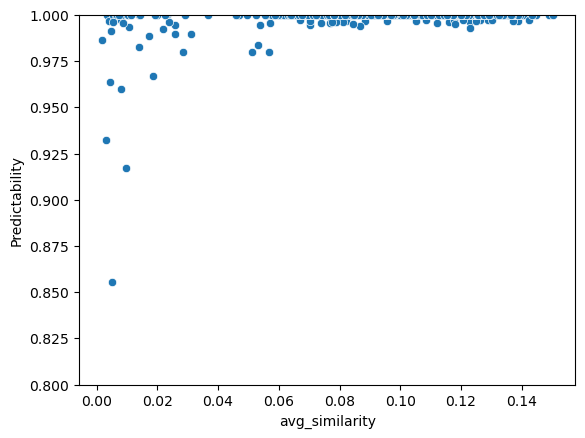

In [54]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.scatterplot(x="avg_similarity", y="Predictability", data=train_df[train_df['generated']==1])
plt.ylim(0.8,1)

In [58]:
train_df

,prompt_id,text,generated,max_similarity,avg_similarity,Predictability
0,0,Cars. Cars have been around since they became ...,0,None,None,None
1,0,Transportation is a large necessity in most co...,0,None,None,None
2,0,Americas love affair with its vehicles seems t...,0,None,None,None
3,0,How often do you ride in a car Do you drive a ...,0,None,None,None
4,0,Cars are a wonderful thing. They are perhaps o...,0,None,None,None
...,...,...,...,...,...,...
2629,1,letter_to_state_senator \n recipient Senator L...,1,0.020836,0.090249,1.0
2630,0,Limiting car usage offers numerous advantages ...,1,0.306796,0.092755,1.0
2631,1,letter \n recipient State Senator\n address St...,1,0.008905,0.104442,0.999992
2632,0,Due to the character limit I cannot provide a ...,1,0.050336,0.019247,0.999998


In [59]:
x = train_df[train_df['generated']==1]['avg_similarity']
y = train_df[train_df['generated']==1]['Predictability']

In [68]:
from scipy.stats.stats import pearsonr
pearsonr(x,y)

C:\Users\vassi\AppData\Local\Temp\ipykernel_1312\1894363853.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.017274348542034943, pvalue=0.5398084749425399)

In [60]:
 x.corr(y, method='spearman')

-0.12985119544326149

In [62]:
x.corr(y, method='kendall')

-0.09330129409532092

In [43]:
texts = train_df['text']
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)
most_common_words = tfidf_df.mean().sort_values(ascending=False)
print(most_common_words.head(10))

electoral         0.142491
college           0.122634
car               0.091830
vote              0.082164
states            0.069362
usage             0.063281
cars              0.060621
popular           0.051062
people            0.049139
transportation    0.046549
dtype: float64
